In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras
import keras.backend as K
from keras import Model
from keras.models import Sequential
from keras.layers import Input, Softmax, Conv1D, Dense, Dropout, ReLU, MaxPooling1D, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

# Split data into training and test partitions
def createSet(dataset):
    x_cols = [col for col in dataset.columns if (col != 'label' and col != 'record')]
    X_data = dataset[x_cols].values
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], -1))
    Y_data = dataset['label'].values

    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, random_state=0, test_size=0.3, train_size=0.7)

    num_classes = len(np.unique(Y_data))

    return num_classes, X_train, X_test, Y_train, Y_test

# Convert class vectors to binary class matrices
def binaryConvertion(num_classes, Y_train, Y_test):
    Y_train_encoder = sklearn.preprocessing.LabelEncoder()
    Y_train_num = Y_train_encoder.fit_transform(Y_train)
    Y_train_wide = np_utils.to_categorical(Y_train_num, num_classes)

    Y_test_num = Y_train_encoder.transform(Y_test)
    Y_test_wide = np_utils.to_categorical(Y_test_num, num_classes)

    return Y_train_wide, Y_test_num, Y_test_wide

def createSiameseModel(input_shape):
    model = Sequential()

    model.add(Conv1D(16, 7, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=3, strides=2))

    model.add(Conv1D(32, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=2))

    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=2))

    model.add(Conv1D(128, 7, activation='relu'))

    model.add(Conv1D(256, 7, activation='relu'))

    model.add(Conv1D(256, 8, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())

    return model

def siameseDistance(x):
    x1, x2 = x  # Unpack the inputs

    return K.abs(x1 - x2)  # Calculate the absolute difference


def siameseModel(X_train, Y_train_wide):
    input_shape = X_train.shape[1:]
    
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    base_network = createSiameseModel(input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = keras.layers.Lambda(siameseDistance)([processed_a, processed_b])
    similarity = Dense(1, activation='sigmoid')(distance)

    model = Model(inputs=[input_a, input_b], outputs=similarity)

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    model.summary()

    # Training
    batch_size = 16
    epochs = 20

    best_weights_filepath = './best_weights.hdf5'
    mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                        save_best_only=True, save_weights_only=False)

    history = model.fit([X_train, X_train], Y_train_wide,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.2,
                        shuffle=True,
                        callbacks=[mcp])

    model.load_weights(best_weights_filepath)
    model.save('model.h5')

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss, 'blue', label='Training Loss')
    plt.plot(val_loss, 'green', label='Validation Loss')
    plt.xticks(range(0, epochs)[0::2])
    plt.legend()
    plt.show()

    return model


def evaluation(model, X_test, Y_test_num):
    pred = np.round(model.predict([X_test, X_test])).flatten().astype(int)
    print(metrics.classification_report(Y_test_num, pred))

if __name__ == "__main__":
    dataset_name = 'PTB_dataset'
    path =  dataset_name + '.csv'
    dataset = pd.read_csv(path)
    num_classes, X_train, X_test, Y_train, Y_test = createSet(dataset)
    Y_train_wide, Y_test_num, Y_test_wide = binaryConvertion(num_classes, Y_train, Y_test)
    print("Shapes before reshaping:")
    print("Y_train_wide shape:", Y_train_wide.shape)
    print("X_train shape:", X_train.shape)
    Y_train_wide = np.reshape(Y_train_wide, (Y_train_wide.shape[0], 1))

    model = siameseModel(X_train, Y_train_wide)
    evaluation(model, X_test, Y_test_num)


Shapes before reshaping:
Y_train_wide shape: (38360, 289)
X_train shape: (38360, 200, 1)


ValueError: cannot reshape array of size 11086040 into shape (38360,1)

In [64]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import numpy as np
music_data = pd.read_csv('PTB_dataset.csv')
music_data.head

<bound method NDFrame.head of             label    record         0         1         2         3         4  \
0      patient001  s0010_re -0.117579 -0.093424 -0.107387 -0.103681 -0.161958   
1      patient001  s0010_re -0.034259 -0.029702 -0.061882 -0.052670 -0.103438   
2      patient001  s0010_re -0.049167 -0.055167 -0.067560 -0.120461 -0.143498   
3      patient001  s0010_re -0.066836 -0.051777 -0.029607 -0.064830 -0.107699   
4      patient001  s0010_re -0.049167 -0.055167 -0.067560 -0.120461 -0.143498   
...           ...       ...       ...       ...       ...       ...       ...   
54795  patient294  s0559_re -0.963768 -0.955776 -0.949161 -0.970347 -0.956256   
54796  patient294  s0559_re -0.977799 -0.949484 -0.939105 -0.961956 -0.971080   
54797  patient294  s0559_re -0.925272 -0.935140 -0.925905 -0.950817 -0.957946   
54798  patient294  s0559_re -0.937705 -0.932561 -0.952624 -0.947619 -0.947541   
54799  patient294  s0559_re -0.919843 -0.928174 -0.939760 -0.942693 -0.952677  

In [76]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the data from CSV
data = pd.read_csv('PTB_dataset.csv')  # Modify the filename accordingly

# Preprocess the data
# Exclude non-numeric columns
numeric_cols = [col for col in data.columns if data[col].dtype != 'object']

# Convert label column to numeric using label encoding
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Extract the input features and labels from the data
X_data = data[numeric_cols].values
Y_data = data['label'].values

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

# Reshape the data to match the input shape of the Siamese network
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Define the Siamese network architecture


In [66]:
print(X_train)

[[[-0.91205598]
  [-0.93863116]
  [-0.92502344]
  ...
  [ 0.58261372]
  [ 0.47579821]
  [ 0.31018156]]

 [[-0.5271552 ]
  [-0.5136299 ]
  [-0.50649631]
  ...
  [-0.45526452]
  [-0.44142021]
  [-0.44804048]]

 [[-0.59202338]
  [-0.64201298]
  [-0.58551538]
  ...
  [-0.69953282]
  [-0.59789972]
  [-0.59328689]]

 ...

 [[-0.66727542]
  [-0.68886482]
  [-0.68939943]
  ...
  [-0.77226208]
  [-0.64885377]
  [-0.61327769]]

 [[-0.5977023 ]
  [-0.57666079]
  [-0.57651336]
  ...
  [-0.53821678]
  [-0.52564202]
  [-0.51782077]]

 [[-0.6353289 ]
  [-0.72206436]
  [-0.67524823]
  ...
  [-0.6173536 ]
  [-0.64906773]
  [-0.61027824]]]


In [154]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load your DataFrame
data = pd.read_csv('PTB_dataset.csv')  

def create_positive_pairs(data):
    data = data.sort_values(by='label')
    patient_ids, patient_indices = np.unique(data['label'], return_index=True)

    x = data.iloc[:, 2:].values

    pairs = []
    labels = []
    for idx in range(len(patient_indices) - 1):
        for i in range(patient_indices[idx], patient_indices[idx + 1] - 1):
            # Positive example pair (Same patient)
            pairs += [[x[i], x[i + 1]]]
            labels += [1]
            
    return np.array(pairs), np.array(labels)

X = data.iloc[:, 2:].values
y = data['label'].values

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=y, random_state=42)

# Create pairs on train and test datasets
tr_pairs, tr_y = create_positive_pairs(X_train)
te_pairs, te_y = create_positive_pairs(X_test)


In [216]:
def create_pairs(data, positive_label):
    data = data.sort_values(by='label')
    patient_ids, patient_indices = np.unique(data['label'], return_index=True)
    patient_indices = np.append(patient_indices, len(data))  # append the length of the data as the last index

    x = data.iloc[:, 2:].values

    positive_pairs = []
    negative_pairs = []
    for idx, patient_id in enumerate(patient_ids):
        if patient_id == positive_label:
            for i in range(patient_indices[idx], patient_indices[idx + 1] - 1):
                # Positive example pair (Same patient)
                positive_pairs += [[x[i], x[i + 1]]]
        else:
            for i in range(patient_indices[idx], patient_indices[idx + 1] - 1):
                # Negative example pair (Different patient)
                negative_pairs += [[x[i], x[i + 1]]]

    positive_labels = np.ones(len(positive_pairs))
    negative_labels = np.zeros(len(negative_pairs))

    return np.array(positive_pairs), positive_labels, np.array(negative_pairs), negative_labels



# Create pairs on the full dataset
positive_pairs, positive_labels, negative_pairs, negative_labels = create_pairs(data, 'patient290')
# Truncate negative pairs and negative labels to match the length of positive pairs and positive labels
negative_pairs = negative_pairs[:len(positive_pairs)]
negative_labels = negative_labels[:len(positive_labels)]



In [217]:
# Combine positive and negative pairs and their respective labels
pairs = np.concatenate((positive_pairs, negative_pairs), axis=0)
labels = np.concatenate((positive_labels, negative_labels), axis=0)

# Split the pairs into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, stratify=labels, random_state=42)


In [218]:
x_train = np.expand_dims(X_train, axis=-1)
x_test = np.expand_dims(X_test, axis=-1)

input_shape = x_train.shape[2:]  # Adjust input shape




In [220]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Subtract

def contrastive_loss(y_true, y_pred):
    margin = 1.0  # Separation margin
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean((1 - y_true) * 0.5 * square_pred + y_true * 0.5 * margin_square)

# Create the Siamese network with modified architecture
siamese_net = create_siamese_network(input_shape)

# Compile the Siamese network with contrastive loss and desired optimizer
siamese_net.compile(loss=contrastive_loss, optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the Siamese network
siamese_net.fit([x_train[:, 0], x_train[:, 1]], y_train,
                batch_size=32, epochs=10,
                validation_data=([x_test[:, 0], x_test[:, 1]], y_test))


Epoch 1/10
5/5 [==============================] - 1s 56ms/step - loss: 0.1260 - accuracy: 0.3481 - val_loss: 0.1261 - val_accuracy: 0.3750
Epoch 2/10
5/5 [==============================] - 0s 23ms/step - loss: 0.1250 - accuracy: 0.4873 - val_loss: 0.1273 - val_accuracy: 0.2250
Epoch 3/10
5/5 [==============================] - 0s 22ms/step - loss: 0.1243 - accuracy: 0.5759 - val_loss: 0.1290 - val_accuracy: 0.1750
Epoch 4/10
5/5 [==============================] - 0s 24ms/step - loss: 0.1237 - accuracy: 0.5886 - val_loss: 0.1311 - val_accuracy: 0.1250
Epoch 5/10
5/5 [==============================] - 0s 26ms/step - loss: 0.1230 - accuracy: 0.5823 - val_loss: 0.1333 - val_accuracy: 0.1750
Epoch 6/10
5/5 [==============================] - 0s 20ms/step - loss: 0.1225 - accuracy: 0.6013 - val_loss: 0.1361 - val_accuracy: 0.1500
Epoch 7/10
5/5 [==============================] - 0s 24ms/step - loss: 0.1219 - accuracy: 0.5949 - val_loss: 0.1394 - val_accuracy: 0.1500
Epoch 8/10
5/5 [===========

In [215]:
unique_labels = np.unique(y_test)
print(unique_labels)
len(positive_pairs)

[0. 1.]


99

In [203]:
from tensorflow.keras.layers import subtract

def create_siamese_network(input_shape):
    # Define the left input layer
    left_input = Input(shape=input_shape)
    
    # Define the right input layer
    right_input = Input(shape=input_shape)
    
    # Shared layers
    conv1 = Conv1D(16, kernel_size=3, activation='relu')
    conv2 = Conv1D(32, kernel_size=3, activation='relu')
    flatten = Flatten()
    dense1 = Dense(128, activation='relu')
    
    # Apply shared layers to left input
    encoded_l = conv1(left_input)
    encoded_l = conv2(encoded_l)
    encoded_l = flatten(encoded_l)
    encoded_l = dense1(encoded_l)
    
    # Apply shared layers to right input
    encoded_r = conv1(right_input)
    encoded_r = conv2(encoded_r)
    encoded_r = flatten(encoded_r)
    encoded_r = dense1(encoded_r)
    
    # Calculate L1 distance between the encoded representations
    subtraction = Subtract()([encoded_l, encoded_r])
    output = Dense(1, activation='sigmoid')(subtraction)
    
    # Create the siamese network model
    siamese_net = Model(inputs=[left_input, right_input], outputs=output)
    
    return siamese_net



In [155]:
# Add an extra dimension to your data
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)





In [165]:
te_y = np.ones((10652,))  # Assuming te_y is initially filled with all 1 values

# Change all values in te_y to 0
te_y = np.zeros_like(te_y)

# Print the updated te_y variable
print(te_y)

[0. 0. 0. ... 0. 0. 0.]


In [166]:
tr_pairs = tr_pairs.reshape(tr_pairs.shape[0], tr_pairs.shape[1], tr_pairs.shape[2], 1)
te_pairs = te_pairs.reshape(te_pairs.shape[0], te_pairs.shape[1], te_pairs.shape[2], 1)

# Check the shape of the arrays
print(tr_pairs[:, 0].shape)
print(tr_pairs[:, 1].shape)
print(te_pairs[:, 0].shape)
print(te_pairs[:, 1].shape)
input_shape = (200, 1)
siamese_net = create_siamese_network(input_shape)
siamese_net.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
# Now, train the network again
history = siamese_net.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=32, epochs=10, 
              validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))


(43472, 200, 1)
(43472, 200, 1)
(10652, 200, 1)
(10652, 200, 1)
Epoch 1/10
1359/1359 [==============================] - 15s 11ms/step - loss: 0.4467 - accuracy: 0.9953 - val_loss: 1.4295 - val_accuracy: 0.0000e+00
Epoch 2/10
1359/1359 [==============================] - 14s 10ms/step - loss: 0.1877 - accuracy: 1.0000 - val_loss: 2.1417 - val_accuracy: 0.0000e+00
Epoch 3/10
1359/1359 [==============================] - 13s 10ms/step - loss: 0.0900 - accuracy: 1.0000 - val_loss: 2.7934 - val_accuracy: 0.0000e+00
Epoch 4/10
1359/1359 [==============================] - 14s 10ms/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 3.4054 - val_accuracy: 0.0000e+00
Epoch 5/10
1359/1359 [==============================] - 14s 11ms/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 3.9952 - val_accuracy: 0.0000e+00
Epoch 6/10
1359/1359 [==============================] - 13s 10ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 4.5730 - val_accuracy: 0.0000e+00
Epoch 7/10
1359/1359 [==============

In [222]:
# Generate predictions
predictions = siamese_net.predict([x_test[:, 0], x_test[:, 1]])
similar_prediction = siamese_net.predict([tr_pairs[:, 0], tr_pairs[:, 1]])

1359/1359 [==============================] - 3s 2ms/step


In [223]:
# Convert the output probabilities to binary predictions
threshold = 0.5
binary_predictions = [1 if pred > threshold else 0 for pred in predictions]
from sklearn.metrics import confusion_matrix, classification_report

# Generate the confusion matrix
print(confusion_matrix(y_test, binary_predictions))

# Generate the classification report
#print(classification_report(y_test, binary_predictions))


[[ 2 18]
 [14  6]]
              precision    recall  f1-score   support

         0.0       0.12      0.10      0.11        20
         1.0       0.25      0.30      0.27        20

    accuracy                           0.20        40
   macro avg       0.19      0.20      0.19        40
weighted avg       0.19      0.20      0.19        40



In [125]:
import matplotlib.pyplot as plt
import numpy as np



# Separate positive and negative test data
positive_images = [x_test[i] for i in range(len(x_test)) if y_test[i] == 1]
negative_images = [x_test[i] for i in range(len(x_test)) if y_test[i] == 0]

# Separate correct and incorrect predictions based on a threshold
threshold = 0.5  # Threshold for classification
correct_predictions = [x_test[i] for i in range(len(x_test)) if predictions[i] >= threshold]
incorrect_predictions = [x_test[i] for i in range(len(x_test)) if predictions[i] < threshold]

# Create the plot
fig, ax = plt.subplots()

# Plot positive images
positive_x = [point[0] for point in positive_images]
positive_y = [point[1] for point in positive_images]
ax.scatter(positive_x, positive_y, color='green', label='Positive')

# Plot negative images
negative_x = [point[0] for point in negative_images]
negative_y = [point[1] for point in negative_images]
ax.scatter(negative_x, negative_y, color='red', label='Negative')

# Plot correct predictions
correct_x = [point[0] for point in correct_predictions]
correct_y = [point[1] for point in correct_predictions]
ax.scatter(correct_x, correct_y, color='blue', label='Correct Prediction')

# Plot incorrect predictions
incorrect_x = [point[0] for point in incorrect_predictions]
incorrect_y = [point[1] for point in incorrect_predictions]
ax.scatter(incorrect_x, incorrect_y, color='orange', label='Incorrect Prediction')

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Dot Plot Graph')

# Add cluster representation
ax.annotate('Cluster 1', xy=(2.5, 6), xytext=(3, 7),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
ax.annotate('Cluster 2', xy=(6.5, 3), xytext=(5, 5),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

# Add legend
ax.legend()

# Show the plot
plt.show()


ValueError: Cannot take a larger sample than population when 'replace=False'

1359/1359 [==============================] - 4s 3ms/step


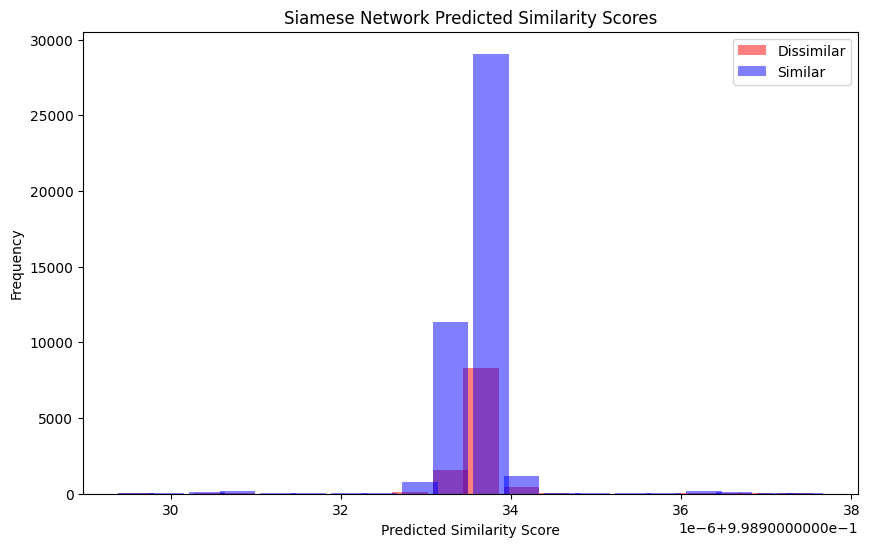

In [172]:
import matplotlib.pyplot as plt

# Get the predicted similarity scores for dissimilar and similar pairs
dissimilar_predictions = siamese_net.predict([te_pairs[:, 0], te_pairs[:, 1]])
similar_predictions = siamese_net.predict([tr_pairs[:, 0], tr_pairs[:, 1]])

# Plot histograms
plt.figure(figsize=(10, 6))

# Dissimilar pairs
plt.hist(dissimilar_predictions, bins=20, alpha=0.5, color='red', label='Dissimilar')
# Similar pairs
plt.hist(similar_predictions, bins=20, alpha=0.5, color='blue', label='Similar')

# Set plot labels and title
plt.xlabel('Predicted Similarity Score')
plt.ylabel('Frequency')
plt.title('Siamese Network Predicted Similarity Scores')
plt.legend()

# Show the plot
plt.show()


1359/1359 [==============================] - 4s 3ms/step


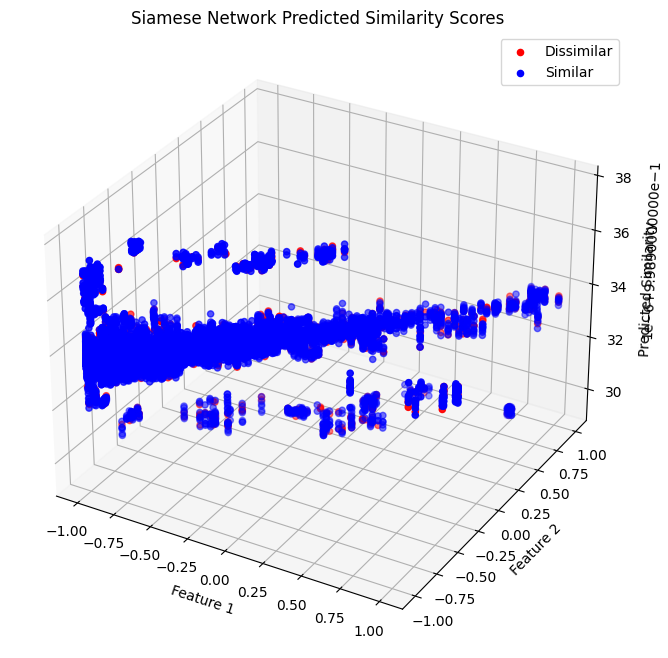

In [173]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get the predicted similarity scores for dissimilar and similar pairs
dissimilar_predictions = siamese_net.predict([te_pairs[:, 0], te_pairs[:, 1]])
similar_predictions = siamese_net.predict([tr_pairs[:, 0], tr_pairs[:, 1]])

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot dissimilar points
ax.scatter(te_pairs[:, 0][:, 0], te_pairs[:, 0][:, 1], dissimilar_predictions, c='red', label='Dissimilar')
# Plot similar points
ax.scatter(tr_pairs[:, 0][:, 0], tr_pairs[:, 0][:, 1], similar_predictions, c='blue', label='Similar')

# Set plot labels and title
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Predicted Similarity')
ax.set_title('Siamese Network Predicted Similarity Scores')

# Add legend
ax.legend()

# Show the plot
plt.show()


In [196]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get the predicted similarity scores for dissimilar and similar pairs
dissimilar_predictions = siamese_net.predict([x_test[:, 0], x_test[:, 1]])
similar_predictions = siamese_net.predict([x_train[:, 0], x_train[:, 1]])




5/5 [==============================] - 0s 2ms/step


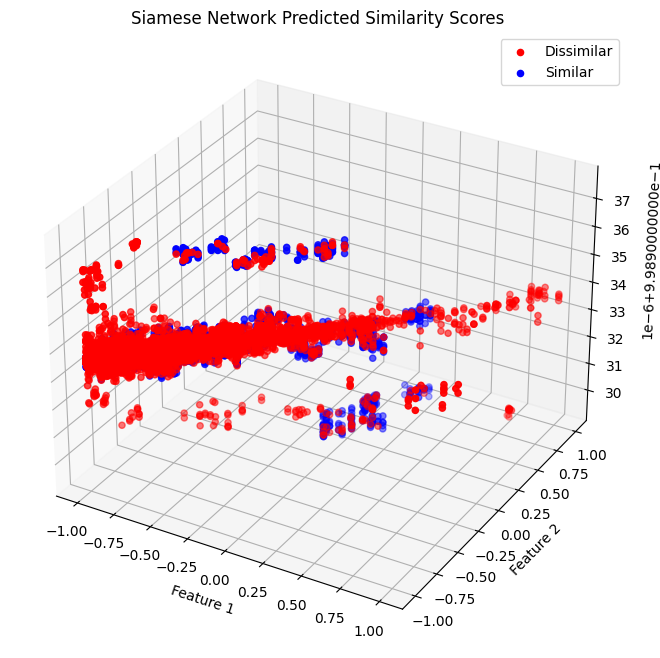

In [180]:
# Choose the number of points for each plot
num_points = min(len(dissimilar_predictions), len(similar_predictions))

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot dissimilar points
ax.scatter(te_pairs[:, 0][:num_points, 0], te_pairs[:, 0][:num_points, 1], dissimilar_predictions[:num_points], c='red', label='Dissimilar')
# Plot similar points
ax.scatter(tr_pairs[:, 0][:num_points, 0], tr_pairs[:, 0][:num_points, 1], similar_predictions[:num_points], c='blue', label='Similar')

# Set plot labels and title
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Predicted Similarity')
ax.set_title('Siamese Network Predicted Similarity Scores')

# Add legend
ax.legend()

# Show the plot
plt.show()

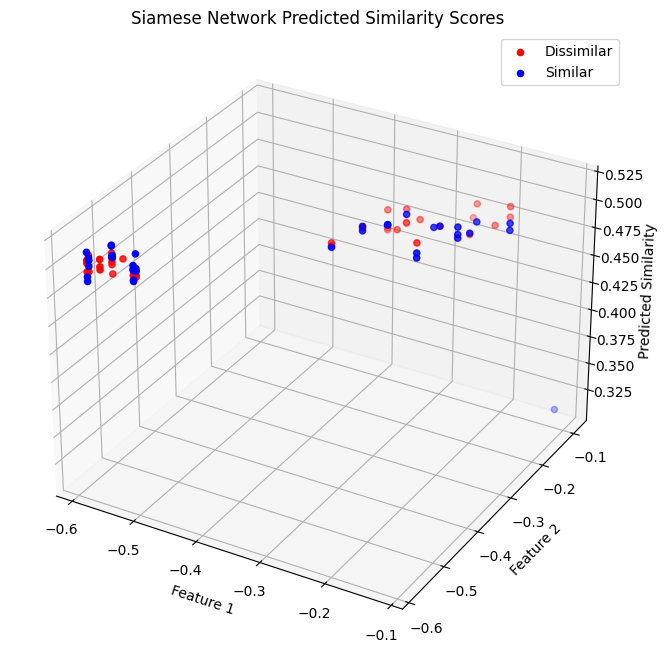

In [224]:
# Choose the number of points for each plot
num_points = min(len(dissimilar_predictions), len(similar_predictions))

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot dissimilar points
ax.scatter(x_test[:, 0][:num_points, 0], x_test[:, 0][:num_points, 1], dissimilar_predictions[:num_points], c='red', label='Dissimilar')
# Plot similar points
ax.scatter(x_train[:, 0][:num_points, 0], x_train[:, 0][:num_points, 1], similar_predictions[:num_points], c='blue', label='Similar')

# Set plot labels and title
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Predicted Similarity ')
ax.set_title('Siamese Network Predicted Similarity Scores')

# Add legend
ax.legend()

# Show the plot
plt.show()

In [227]:
siamese_net.save('siamese_net.h5')


In [266]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def contrastive_loss(y_true, y_pred):
    margin = 1.0  # Separation margin
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean((1 - y_true) * 0.5 * square_pred + y_true * 0.5 * margin_square)

# Load the Siamese network model
siamese_net = load_model('siamese_net.h5', custom_objects={'contrastive_loss': contrastive_loss})

# Compile the model with desired optimizer and metrics
siamese_net.compile(loss=contrastive_loss, optimizer=Adam(lr=0.001), metrics=['accuracy'])


In [256]:
import pandas as pd

# Load the Physionet.csv dataset
data = pd.read_csv('Physionet.csv')

# Preprocess the data
# Drop unnecessary columns (e.g., 'record')
data = data.drop(columns=['record'])

# Select a subset of samples for testing (e.g., patient001 vs. patient002)
test_data = data[(data['label'] == 'patient290') | (data['label'] == 'patient002')]

# Create pairs for testing
test_pairs = create_pairs(test_data, positive_label='patient290')[0]  # Only need positive pairs for testing


In [275]:
print(data)

            label         0         1         2         3         4         5  \
0      patient001 -0.038663 -0.038344 -0.029588 -0.065324 -0.101003 -0.288070   
1      patient001 -0.043308 -0.069143 -0.040227 -0.073417 -0.132275 -0.286137   
2      patient001 -0.043308 -0.069143 -0.040227 -0.073417 -0.132275 -0.286137   
3      patient001 -0.038663 -0.038344 -0.029588 -0.065324 -0.101003 -0.288070   
4      patient001 -0.117579 -0.093424 -0.107387 -0.103681 -0.161958 -0.304563   
...           ...       ...       ...       ...       ...       ...       ...   
54795  patient294 -0.963768 -0.955776 -0.949161 -0.970347 -0.956256 -1.000000   
54796  patient294 -0.943506 -0.949993 -0.948094 -0.943814 -0.963927 -1.000000   
54797  patient294 -0.964992 -0.944260 -0.945734 -0.939079 -0.960828 -1.000000   
54798  patient294 -0.964992 -0.944260 -0.945734 -0.939079 -0.960828 -1.000000   
54799  patient294 -0.919843 -0.928174 -0.939760 -0.942693 -0.952677 -0.990091   

              6         7  

In [273]:
import numpy as np
from keras.models import load_model



x_test = test_data.iloc[:, 1:].values  # Extract the features
x_test_reshaped = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  # Reshape for Siamese network

# Compute similarities using the Siamese network
similarities = siamese_net.predict([x_test_reshaped[:, :, :], x_test_reshaped[:, :, :]])

# Print the similarities
print(similarities)


7/7 [==============================] - 0s 3ms/step
[[0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 [0.500299]
 

In [271]:
print(siamese_net.summary())

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_72 (InputLayer)          [(None, 200, 1)]     0           []                               
                                                                                                  
 input_73 (InputLayer)          [(None, 200, 1)]     0           []                               
                                                                                                  
 conv1d_118 (Conv1D)            (None, 198, 16)      64          ['input_72[0][0]',               
                                                                  'input_73[0][0]']               
                                                                                                  
 conv1d_119 (Conv1D)            (None, 196, 32)      1568        ['conv1d_118[0][0]',      

In [269]:
import numpy as np


x_test = test_data.iloc[:, 1:].values  # Extract the features
x_test_reshaped = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  # Reshape for Siamese network

# Compute similarities using the Siamese network
predictions = siamese_net.predict([x_test_reshaped[:, 0, :], x_test_reshaped[:, 1, :]])

# Print the similarities
print(predictions)

ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'conv1d_118' (type Conv1D).
    
    Negative dimension size caused by subtracting 3 from 1 for '{{node model_31/conv1d_118/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](model_31/conv1d_118/Conv1D/ExpandDims, model_31/conv1d_118/Conv1D/ExpandDims_1)' with input shapes: [?,1,1,1], [1,3,1,16].
    
    Call arguments received by layer 'conv1d_118' (type Conv1D):
      • inputs=tf.Tensor(shape=(None, 1, 1), dtype=float32)


5/5 [==============================] - 0s 2ms/step


TypeError: only length-1 arrays can be converted to Python scalars

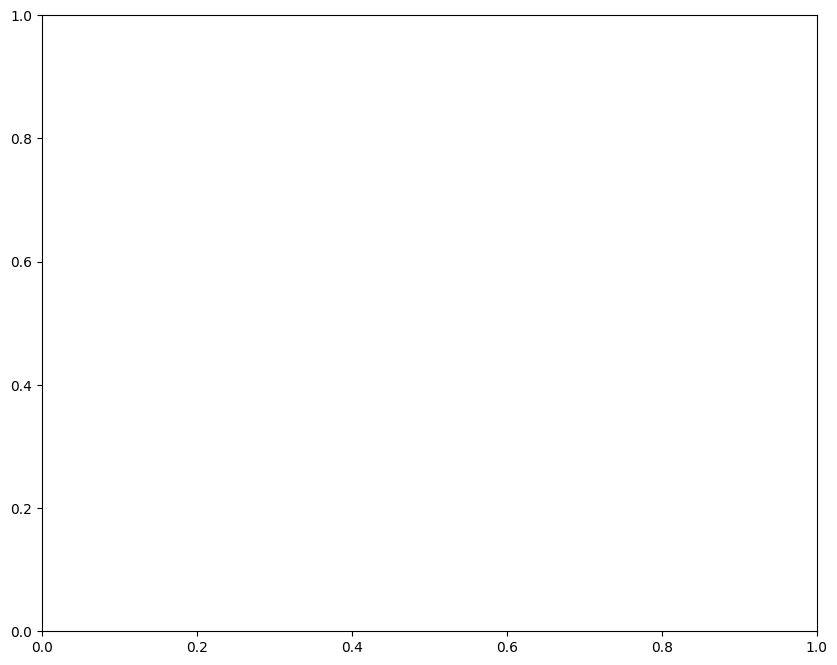

In [239]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Compute similarities using your Siamese network
similarities = siamese_net.predict([x_test_reshaped[:, 0, :, :], x_test_reshaped[:, 1, :, :]])



# Compute similarities using your Siamese network
similaritiies = siamese_net.predict([x_train[:, 0], x_train[:, 1]])

# Create a bar graph
fig = plt.figure(figsize=(10, 8))
plt.bar(range(len(similaritiies)), similarities)

# Set plot labels and title
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Siamese Network Similarities on x_train')

# Show the plot
plt.show()


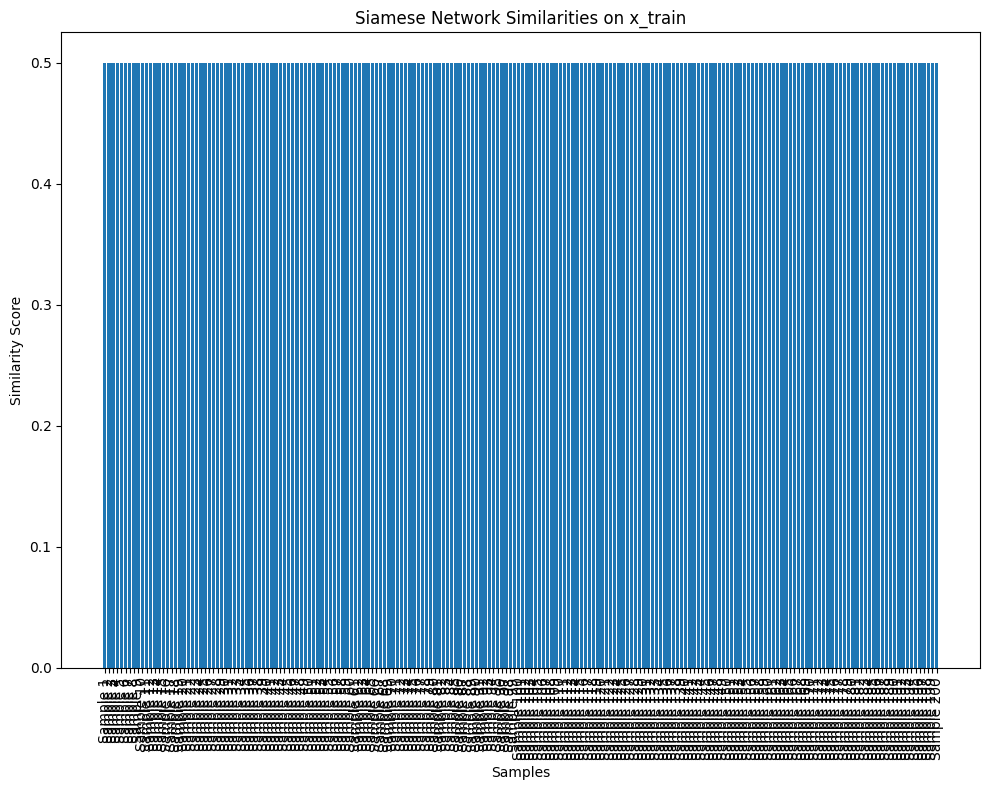

In [274]:
import matplotlib.pyplot as plt
import numpy as np

# Compute similarities using your Siamese network
#similarities = siamese_net.predict([x_test_reshaped[:, 0, :, :], x_test_reshaped[:, 1, :, :]])

# Create a bar graph
fig = plt.figure(figsize=(10, 8))
indices = np.arange(len(similarities))
plt.bar(indices, similarities.flatten())

# Set x-axis labels
x_labels = [f'Sample {i+1}' for i in range(len(similarities))]
plt.xticks(indices, x_labels, rotation='vertical')

# Set plot labels and title
plt.xlabel('Samples')
plt.ylabel('Similarity Score')
plt.title('Siamese Network Similarities on x_train')

# Show the plot
plt.tight_layout()
plt.show()


In [279]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

# Load the data
df_train = pd.read_csv('PTB_dataset.csv')
df_test = pd.read_csv('physionet.csv')

# Prepare the data
# Assuming 'label' is the patient and the remaining columns are ECG data

X_train = df_train.drop(['label', 'record'], axis=1).values
y_train = df_train['label'].values
X_test = df_test.drop('label', axis=1).values
y_test = df_test['label'].values

def create_pairs(x, patient_indices):
    pairs = []
    labels = []

    for patient in patient_indices:
        same_patient = np.where(y_train == patient)[0]
        diff_patient = np.where(y_train != patient)[0]
        for i in range(len(same_patient)):
            pairs += [[x[same_patient[i]], x[same_patient[(i + 1) % len(same_patient)]]]]
            labels += [1]
            pairs += [[x[same_patient[i]], x[diff_patient[np.random.randint(len(diff_patient))]]]]
            labels += [0]
    return np.array(pairs), np.array(labels)

# Create the pairs
patient_indices = np.unique(y_train)
train_pairs, train_y = create_pairs(X_train, patient_indices)

# Siamese Network definition

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

base_network = create_base_network(X_train.shape[1:])

input_a = Input(shape=X_train.shape[1:])
input_b = Input(shape=X_train.shape[1:])

# because we re-use the same instance `base_network`,
# the weights of the network will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
train_y = train_y.astype('float32')

# Train
model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y,
          batch_size=128,
          epochs=20)




Epoch 1/20
857/857 [==============================] - 2s 2ms/step - loss: 0.0560
Epoch 2/20
857/857 [==============================] - 1s 2ms/step - loss: 0.0324
Epoch 3/20
857/857 [==============================] - 1s 2ms/step - loss: 0.0275
Epoch 4/20
857/857 [==============================] - 1s 2ms/step - loss: 0.0248
Epoch 5/20
857/857 [==============================] - 1s 2ms/step - loss: 0.0231
Epoch 6/20
857/857 [==============================] - 1s 2ms/step - loss: 0.0222
Epoch 7/20
857/857 [==============================] - 1s 2ms/step - loss: 0.0216
Epoch 8/20
857/857 [==============================] - 1s 2ms/step - loss: 0.0206
Epoch 9/20
857/857 [==============================] - 1s 2ms/step - loss: 0.0201
Epoch 10/20
857/857 [==============================] - 1s 2ms/step - loss: 0.0196
Epoch 11/20
857/857 [==============================] - 2s 2ms/step - loss: 0.0193
Epoch 12/20
857/857 [==============================] - 1s 2ms/step - loss: 0.0187
Epoch 13/20
857/857 [====

In [278]:
print(train_pairs[:, 0].shape, train_pairs[:, 1].shape, train_y.shape)
print(type(train_pairs[:, 0]), type(train_pairs[:, 1]), type(train_y))


(109600, 200) (109600, 200) (109600,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [284]:
# load your data
df_train = pd.read_csv('PTB_dataset.csv')
df_test = pd.read_csv('physionet.csv')

# pre-process your data
features_train = df_train.drop(['label', 'record'], axis=1)
labels_train = df_train['label']

features_test = df_test.drop(['label', 'record'], axis=1) # 'record' is also dropped
labels_test = df_test['label']

# Check number of features in train and test datasets
assert features_train.shape[1] == features_test.shape[1], \
       f"Number of features do not match: Train = {features_train.shape[1]}, Test = {features_test.shape[1]}"

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

# use a semi-supervised algorithm like k-means
kmeans = KMeans(n_clusters=294, random_state=0).fit(features_train)

# get the cluster centroids
centroids = kmeans.cluster_centers_

# predict the closest cluster each sample in the test set belongs to
test_clusters = kmeans.predict(features_test)

# get the closest users for each test case
closest, _ = pairwise_distances_argmin_min(centroids[test_clusters], features_test)

closest_users = labels_train.iloc[closest].values # .iloc is used because 'closest' is an array of indices

# finding similarities and dissimilarities
similarities = np.where(closest_users == labels_test.values, 1, 0) # .values is used to convert the Series to a numpy array
dissimilarities = np.where(closest_users != labels_test.values, 1, 0)

print(f"Similarities: {np.sum(similarities)}")
print(f"Dissimilarities: {np.sum(dissimilarities)}")


Similarities: 41800
Dissimilarities: 13000


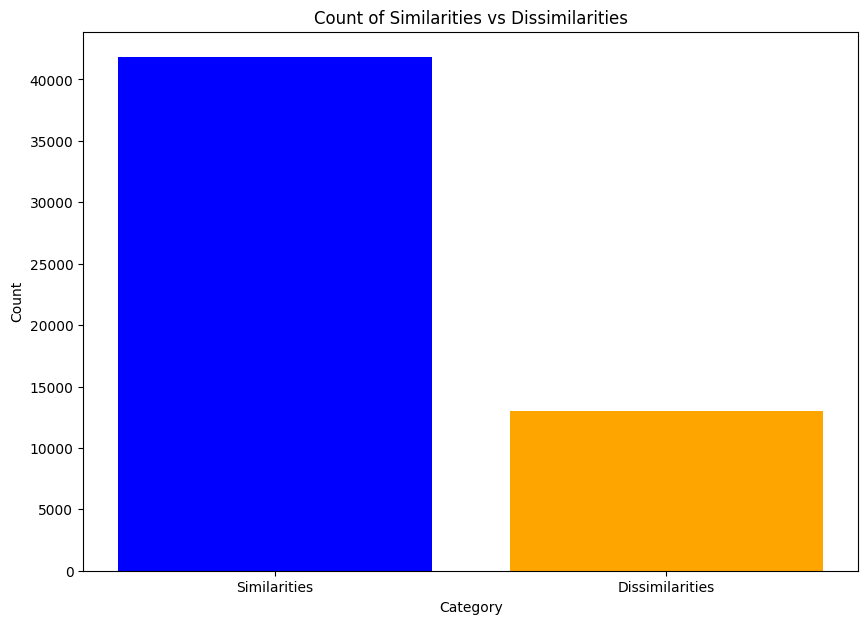

In [285]:
import matplotlib.pyplot as plt

# Calculate similarities and dissimilarities
similarities_count = np.sum(similarities)
dissimilarities_count = np.sum(dissimilarities)

# Data to plot
labels = ['Similarities', 'Dissimilarities']
counts = [similarities_count, dissimilarities_count]

# Create bar plot
plt.figure(figsize=(10,7))
plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Similarities vs Dissimilarities')
plt.show()


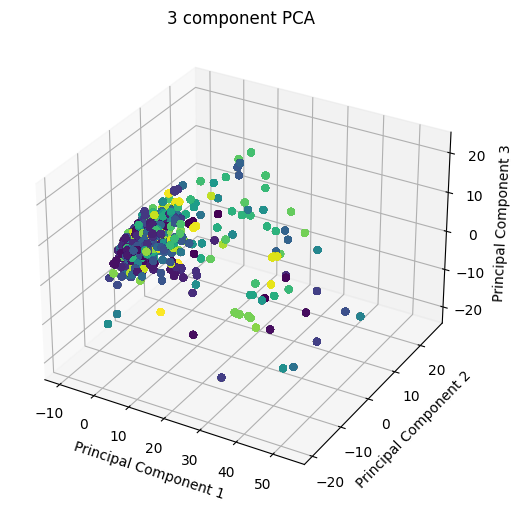

In [287]:
from sklearn.preprocessing import LabelEncoder

# Convert the labels to numeric labels
le = LabelEncoder()
numeric_labels_test = le.fit_transform(labels_test)

# Then, plot as before
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:, 2], c=numeric_labels_test)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3 component PCA')
plt.show()


In [ ]:
########### Model Robustness #########

In [295]:
import pandas as pd

df = pd.read_csv('Physionet.csv')
df.head

<bound method NDFrame.head of             label    record         0         1         2         3         4  \
0      patient001  s0010_re -0.038663 -0.038344 -0.029588 -0.065324 -0.101003   
1      patient001  s0010_re -0.043308 -0.069143 -0.040227 -0.073417 -0.132275   
2      patient001  s0010_re -0.043308 -0.069143 -0.040227 -0.073417 -0.132275   
3      patient001  s0010_re -0.038663 -0.038344 -0.029588 -0.065324 -0.101003   
4      patient001  s0010_re -0.117579 -0.093424 -0.107387 -0.103681 -0.161958   
...           ...       ...       ...       ...       ...       ...       ...   
54795  patient294  s0559_re -0.963768 -0.955776 -0.949161 -0.970347 -0.956256   
54796  patient294  s0559_re -0.943506 -0.949993 -0.948094 -0.943814 -0.963927   
54797  patient294  s0559_re -0.964992 -0.944260 -0.945734 -0.939079 -0.960828   
54798  patient294  s0559_re -0.964992 -0.944260 -0.945734 -0.939079 -0.960828   
54799  patient294  s0559_re -0.919843 -0.928174 -0.939760 -0.942693 -0.952677  

In [296]:
patient1 = df[df['label'] == 'patient001']
patient2 = df[df['label'] == 'patient002']


In [297]:
split_index = len(patient1) // 2
patient1_first_half = patient1.iloc[:split_index]
patient1_second_half = patient1.iloc[split_index:]
patient2_first_half = patient2.iloc[:split_index]
patient2_second_half = patient2.iloc[split_index:]


In [298]:
patient2_combined = pd.concat([patient2_first_half, patient1_second_half])


In [299]:
final_dataset = pd.concat([patient1_first_half, patient2_combined])


In [300]:
import numpy as np
import pandas as pd
import keras



In [306]:
def weightTransform(W, mode = 1, n = 1):

    if mode == 1:
        W_new = W
    elif mode == 2:
        W_new = np.sign(W)
    else:
        W_new = np.round(W * (np.power(2, n)))
    return W_new

In [301]:
def rebuildModelENN(model_path, n):
    model = keras.models.load_model(model_path)
    count = 0
    count_inv = 0
    count_shift = 0
    layer_outputs = []

    for layer in model.layers:
        if layer.name.startswith('dropout'):
            break

        if layer.name.startswith('conv1d'):
            weights = layer.get_weights()
            for i in range(len(weights)):
                w = weightTransform(weights[i], 3, n)
                if i == 0:
                    count = count + np.size(w)
                    count_shift = count_shift + np.size(w)
                    count_inv = count_inv + np.sum(w < 0)
                if i == 1:
                    count = count + np.size(w)

                weights[i] = weightTransform(weights[i], 3, n) / (np.power(2, n))
            layer.set_weights(weights)

        output = layer.output
        layer_outputs.append(output)
    print("Exponent Weight\nAddition Number: ", count, "Inversion Number: ", count_inv, "Bit-shift Number: ", count_shift)
    model_template = keras.Model(inputs=model.input, outputs=layer_outputs)

    return model_template


In [307]:
model_path = 'best_weights.hdf5'  # Replace with the actual model file path
n = 3  # Replace with the desired value for n
model = rebuildModelENN(model_path, 0.94)


Exponent Weight
Addition Number:  824672 Inversion Number:  21036 Bit-shift Number:  823920


In [311]:
model.compile(optimizer='adam', loss='binary_crossentropy')  # Adjust the optimizer and loss function based on your task


In [315]:
import tensorflow as tf
X = final_dataset.drop(columns=['label'])  # Assuming 'label' is the column representing the target variable
y = final_dataset['label']  # Assuming 'label' is the column representing the target variable

# Perform any additional preprocessing steps if required

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)


ValueError: too many values to unpack (expected 2)

In [312]:


# Initialize and train your classification model
classifier = model  # Replace 'YourClassifier' with the appropriate classifier
classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [318]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Load the data
df = pd.read_csv("PTB_dataset.csv")

# Select two patients
patient_1 = df[df['label'] == 'patient001']
patient_2 = df[df['label'] == 'patient294']

# Get half length of patient 2's records
half_len_patient2 = len(patient_2) // 2

# Replace half of the patient 2 records with patient 1 records
patient_2.iloc[:half_len_patient2, 2:] = patient_1.values[:half_len_patient2, 2:]

# Concatenate the two patients data
df_new = pd.concat([patient_1, patient_2])

# Save the new data
df_new.to_csv("Modified_PTB_dataset.csv", index=False)

# Read the processed data
dataset_path = "Modified_PTB_dataset.csv"
dataset = pd.read_csv(dataset_path)

# Select the two patients for testing
test_data = dataset[dataset['label'].isin(['patient001', 'patient294'])]

# Process data and extract features and labels
X_test = test_data.iloc[:, 2:].values
y_test = test_data['label'].values

# Rebuild the model
model_path = "best_weights.hdf5"  # replace with your model path
model = rebuildModelENN(model_path, n=0.94)  # or replace with appropriate model rebuild function

# Predict the probabilities
y_pred_proba = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_proba, axis=1)

# Assuming your model is built for binary classification and the labels are 'patient001' and 'patient294'
# Convert numerical predictions back to string labels
label_map = {0: 'patient001', 1: 'patient294'}
y_pred = np.vectorize(label_map.get)(y_pred)

print(classification_report(y_test, y_pred))


Exponent Weight
Addition Number:  824672 Inversion Number:  21036 Bit-shift Number:  823920
13/13 [==============================] - 0s 4ms/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (16, 400) + inhomogeneous part.

In [319]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming input shape is (10,)
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(10,)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
y_pred_proba = model.predict(X_test)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

Exponent Weight
Addition Number:  824672 Inversion Number:  95406 Bit-shift Number:  823920
9/9 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 20ms/step


Verifying Users |                                | 0%

1/1 [==============================] - 0s 21ms/step


Verifying Users |                                | 0%

1/1 [==============================] - 0s 21ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 23ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 18ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 21ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 16ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 17ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#                               | 6%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##                              | 9%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###                             | 9%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###                             | 12%

1/1 [==============================] - 0s 13ms/step


Verifying Users |####                            | 12%

1/1 [==============================] - 0s 20ms/step


Verifying Users |####                            | 12%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 13ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####                            | 15%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####                            | 15%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#####                           | 15%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 18%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#####                           | 18%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 18%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 13ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 13ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 21%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######                          | 21%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 21%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########                       | 31%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 31%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 31%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 13ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 34%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 34%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 37%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############                    | 37%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############                    | 37%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 13ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############                   | 40%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############                  | 43%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 13ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###############                 | 49%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###############                 | 49%

1/1 [==============================] - 0s 14ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 13ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 15ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 14ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 14ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 14ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 14ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 17ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 14ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#################               | 56%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##################              | 59%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###################             | 62%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####################            | 65%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####################            | 65%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 65%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 68%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 68%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######################          | 68%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 13ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 16ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######################          | 71%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######################          | 71%

1/1 [==============================] - 0s 13ms/step


Verifying Users |######################          | 71%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 16ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 13ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 13ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 27ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########################       | 81%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##########################      | 81%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########################      | 81%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 13ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########################      | 84%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########################     | 84%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########################     | 87%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############################    | 87%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################    | 87%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################    | 90%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################    | 90%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 90%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############################  | 93%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 13ms/step


Verifying Users |############################### | 99%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################### | 99%

1/1 [==============================] - 0s 14ms/step


Verifying Users |################################| 100%


User Accuracy: 0.00%
1/1 [==============================] - 0s 16ms/step


Verifying Intruders |                                | 0%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |                                | 0%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#                               | 3%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#                               | 3%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##                              | 6%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##                              | 6%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##                              | 8%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##                              | 8%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##                              | 9%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###                             | 9%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###                             | 11%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###                             | 11%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###                             | 12%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####                            | 12%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |####                            | 14%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####                            | 14%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |####                            | 15%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |####                            | 15%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#####                           | 15%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#####                           | 17%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####                           | 17%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######                          | 18%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######                          | 19%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######                          | 19%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######                         | 22%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######                         | 22%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########                        | 25%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########                        | 25%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########                       | 31%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##########                      | 31%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##########                      | 31%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##########                      | 34%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###########                     | 34%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###########                     | 34%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########                     | 37%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############                    | 37%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############                    | 40%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#############                   | 40%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 22ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###############                 | 48%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###############                 | 48%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |################                | 51%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |################                | 51%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##################              | 59%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###################             | 59%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###################             | 62%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####################            | 62%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####################            | 65%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |####################            | 65%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#####################           | 65%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#####################           | 68%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#####################           | 68%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |######################          | 68%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######################         | 74%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#######################         | 74%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########################        | 77%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########################        | 77%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#########################       | 79%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#########################       | 79%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########################       | 81%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##########################      | 82%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##########################      | 82%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##########################      | 84%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###########################     | 84%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########################     | 84%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###########################     | 85%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###########################     | 85%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###########################     | 87%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################    | 87%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################    | 88%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |############################    | 88%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |############################    | 90%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#############################   | 90%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############################   | 91%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#############################   | 91%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############################   | 93%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#############################   | 93%

1/1 [==============================] - 0s 12ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############################  | 96%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############################  | 96%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################### | 99%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############################### | 99%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |################################| 100%


Intruder Accuracy: 100.00%
Average Accuracy : 45.95%
[0.4594594594594595]
[54.69389891624451]
Exponent Weight
Addition Number:  824672 Inversion Number:  95406 Bit-shift Number:  823920
9/9 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 17ms/step


Verifying Users |                                | 0%

1/1 [==============================] - 0s 15ms/step


Verifying Users |                                | 0%

1/1 [==============================] - 0s 15ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 14ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 14ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 14ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 15ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 13ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##                              | 9%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###                             | 9%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###                             | 9%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###                             | 12%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 12%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 12%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 16ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 15%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####                            | 15%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 15%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 18%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 18%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 18%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 13ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 21%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 21%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 13ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 16ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##########                      | 31%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########                      | 31%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##########                      | 31%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 13ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 34%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 34%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 34%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###########                     | 37%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 37%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############                    | 37%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#############                   | 40%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 13ms/step


Verifying Users |##############                  | 43%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 13ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###############                 | 49%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###############                 | 49%

1/1 [==============================] - 0s 15ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 14ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 13ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 13ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 15ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 13ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 15ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 14ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 15ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 13ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##################              | 59%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###################             | 62%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####################            | 65%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####################            | 65%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 65%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#####################           | 68%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 68%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######################          | 68%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 16ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 13ms/step


Verifying Users |######################          | 71%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######################          | 71%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 13ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 13ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 13ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########################      | 81%

1/1 [==============================] - 0s 13ms/step


Verifying Users |##########################      | 81%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########################      | 81%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 13ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########################      | 84%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########################     | 84%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########################     | 84%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########################     | 87%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################    | 87%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################    | 87%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################    | 90%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############################    | 90%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############################   | 90%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############################  | 93%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 14ms/step


Verifying Users |############################### | 99%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################### | 99%

1/1 [==============================] - 0s 14ms/step


Verifying Users |################################| 100%


User Accuracy: 0.00%
1/1 [==============================] - 0s 15ms/step


Verifying Intruders |                                | 0%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |                                | 0%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#                               | 3%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#                               | 3%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##                              | 6%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##                              | 6%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##                              | 8%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##                              | 8%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##                              | 8%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##                              | 9%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###                             | 9%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###                             | 11%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###                             | 11%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###                             | 12%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####                            | 12%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####                            | 14%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |####                            | 14%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####                            | 15%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####                            | 15%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#####                           | 17%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#####                           | 17%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |######                          | 18%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |######                          | 19%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |######                          | 19%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######                         | 21%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#######                         | 22%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#######                         | 22%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########                        | 25%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |########                        | 25%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#########                       | 31%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##########                      | 31%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##########                      | 34%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###########                     | 34%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###########                     | 37%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |############                    | 37%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############                    | 37%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############                    | 40%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |############                    | 40%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############                   | 40%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 12ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##############                  | 43%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###############                 | 48%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###############                 | 48%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###############                 | 48%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |################                | 51%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |################                | 51%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |################                | 51%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#################               | 56%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##################              | 59%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###################             | 59%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###################             | 59%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###################             | 62%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###################             | 62%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |####################            | 62%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |####################            | 65%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#####################           | 65%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#####################           | 68%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |######################          | 68%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 12ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######################         | 74%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#######################         | 74%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########################        | 77%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |########################        | 77%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |########################        | 78%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#########################       | 79%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########################       | 79%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#########################       | 81%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##########################      | 82%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##########################      | 82%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########################     | 84%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########################     | 84%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########################     | 85%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###########################     | 85%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |###########################     | 87%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############################    | 87%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################    | 88%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################    | 88%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |############################    | 90%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#############################   | 90%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############################   | 91%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#############################   | 91%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |#############################   | 91%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############################   | 93%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############################   | 93%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |##############################  | 96%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############################  | 96%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################### | 99%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |############################### | 99%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |################################| 100%


Intruder Accuracy: 100.00%
Average Accuracy : 46.56%
[0.4594594594594595, 0.4656188605108055]
[54.69389891624451, 107.11739683151245]
Exponent Weight
Addition Number:  824672 Inversion Number:  95406 Bit-shift Number:  823920
9/9 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 18ms/step


Verifying Users |                                | 0%

1/1 [==============================] - 0s 13ms/step


Verifying Users |                                | 0%

1/1 [==============================] - 0s 14ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 13ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 14ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 14ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 15ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 14ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 9%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###                             | 9%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###                             | 12%

1/1 [==============================] - 0s 13ms/step


Verifying Users |####                            | 12%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 13ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 14ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 15%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 15%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 13ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 18%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#####                           | 18%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 13ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######                          | 21%

1/1 [==============================] - 0s 14ms/step


Verifying Users |######                          | 21%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 16ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 16ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 14ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 13ms/step


Verifying Users |########                        | 28%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 14ms/step


Verifying Users |#########                       | 31%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########                      | 31%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########                      | 31%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 13ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##########                      | 34%

1/1 [==============================] - 0s 13ms/step


Verifying Users |###########                     | 34%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 34%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 14ms/step


Verifying Users |###########                     | 37%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###########                     | 37%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############                    | 37%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 40%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 13ms/step


Verifying Users |##############                  | 43%

1/1 [==============================] - 0s 14ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 20ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 21ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###############                 | 49%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###############                 | 49%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###############                 | 49%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 16ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 17ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 15ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 15ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 15ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#################               | 56%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 17ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##################              | 59%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###################             | 62%

1/1 [==============================] - 0s 17ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 20ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 16ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 19ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 16ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 19ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####################            | 65%

1/1 [==============================] - 0s 19ms/step


Verifying Users |####################            | 65%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#####################           | 65%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####################           | 68%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#####################           | 68%

1/1 [==============================] - 0s 16ms/step


Verifying Users |######################          | 68%

1/1 [==============================] - 0s 16ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 17ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######################          | 71%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######################          | 71%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######################         | 71%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 16ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 17ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 16ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 16ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########################      | 81%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########################      | 81%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 17ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########################      | 84%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 84%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 87%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################    | 87%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 17ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 22ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############################    | 90%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#############################   | 90%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 28ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 17ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 25ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 17ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 38ms/step


Verifying Users |############################### | 99%

1/1 [==============================] - 0s 21ms/step


Verifying Users |############################### | 99%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################################| 100%


User Accuracy: 0.00%
1/1 [==============================] - 0s 17ms/step


Verifying Intruders |                                | 0%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |                                | 0%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#                               | 3%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#                               | 3%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##                              | 6%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |##                              | 6%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |##                              | 8%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |##                              | 8%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##                              | 9%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###                             | 9%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###                             | 11%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###                             | 11%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###                             | 12%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####                            | 12%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 14%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 14%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 15%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |####                            | 15%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#####                           | 15%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 31ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####                           | 17%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#####                           | 17%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |######                          | 18%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######                          | 19%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |######                          | 19%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 22%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |########                        | 25%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 25%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 29ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#########                       | 31%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 31%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |##########                      | 31%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 34%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###########                     | 34%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###########                     | 34%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###########                     | 37%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 37%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 40%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############                   | 40%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 48%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 48%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################                | 51%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################                | 51%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##################              | 59%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###################             | 59%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 62%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####################            | 62%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 65%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |####################            | 65%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 65%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 68%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 68%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |######################          | 68%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######################         | 74%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######################         | 74%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |########################        | 77%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 77%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 79%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#########################       | 79%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#########################       | 81%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##########################      | 82%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 82%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##########################      | 84%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 84%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 84%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 85%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 85%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 87%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 87%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 88%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 88%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 90%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#############################   | 90%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 91%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 91%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#############################   | 93%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 93%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##############################  | 96%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 96%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |############################### | 99%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################### | 99%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################################| 100%


Intruder Accuracy: 100.00%
Average Accuracy : 47.13%
[0.4594594594594595, 0.4656188605108055, 0.47128712871287126]
[54.69389891624451, 107.11739683151245, 166.74500679969788]
Exponent Weight
Addition Number:  824672 Inversion Number:  95406 Bit-shift Number:  823920
9/9 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 20ms/step


Verifying Users |                                | 0%

1/1 [==============================] - 0s 15ms/step


Verifying Users |                                | 0%

1/1 [==============================] - 0s 17ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 16ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 15ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 15ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 18ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 18ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#                               | 6%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 28ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 17ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 17ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##                              | 9%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###                             | 9%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###                             | 9%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###                             | 12%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###                             | 12%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####                            | 12%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 19ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 19ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 20ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 19ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 20ms/step


Verifying Users |####                            | 15%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 15%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 18%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 18%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######                          | 18%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 17ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 17ms/step


Verifying Users |######                          | 21%

1/1 [==============================] - 0s 23ms/step


Verifying Users |######                          | 21%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######                         | 21%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 17ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 16ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 15ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########                        | 28%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#########                       | 31%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 31%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##########                      | 31%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 20ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 34%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########                     | 34%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########                     | 37%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 37%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 37%

1/1 [==============================] - 0s 17ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 40%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 23ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 43%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###############                 | 49%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###############                 | 49%

1/1 [==============================] - 0s 17ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 19ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 17ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 16ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 19ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#################               | 56%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##################              | 59%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###################             | 62%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###################             | 62%

1/1 [==============================] - 0s 16ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 17ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 16ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 17ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####################            | 65%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#####################           | 65%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####################           | 68%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####################           | 68%

1/1 [==============================] - 0s 19ms/step


Verifying Users |######################          | 68%

1/1 [==============================] - 0s 19ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 17ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######################          | 71%

1/1 [==============================] - 0s 19ms/step


Verifying Users |######################          | 71%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#######################         | 71%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 21ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 20ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 20ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 20ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########################        | 78%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 21ms/step


Verifying Users |#########################       | 81%

1/1 [==============================] - 0s 20ms/step


Verifying Users |##########################      | 81%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########################      | 81%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########################      | 84%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###########################     | 84%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###########################     | 87%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################    | 87%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############################    | 87%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 17ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 17ms/step


Verifying Users |############################    | 90%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############################    | 90%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 90%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 23ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##############################  | 93%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 17ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 34ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 16ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################### | 99%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############################### | 99%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################################| 100%


User Accuracy: 0.00%
1/1 [==============================] - 0s 18ms/step


Verifying Intruders |                                | 0%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |                                | 0%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |                                | 3%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#                               | 3%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#                               | 3%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#                               | 6%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 6%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |##                              | 6%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 8%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 8%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##                              | 9%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###                             | 9%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###                             | 11%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###                             | 11%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###                             | 12%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |####                            | 12%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 103ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |####                            | 14%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 14%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 15%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####                           | 15%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####                           | 17%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#####                           | 17%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######                          | 19%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |######                          | 19%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#######                         | 22%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 25%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 25%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##########                      | 31%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##########                      | 31%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##########                      | 34%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |###########                     | 34%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###########                     | 37%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 37%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############                    | 40%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 40%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############                   | 40%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 43%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 46%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 48%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 48%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################                | 51%

1/1 [==============================] - 0s 22ms/step


Verifying Intruders |################                | 51%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################                | 53%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 56%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##################              | 59%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###################             | 59%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 62%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####################            | 62%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |####################            | 65%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 65%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#####################           | 68%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 68%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#######################         | 74%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#######################         | 74%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |########################        | 77%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |########################        | 77%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 79%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#########################       | 79%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 82%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 82%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 84%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 84%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 85%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###########################     | 85%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 29ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###########################     | 87%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############################    | 87%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 88%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 88%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 90%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############################    | 90%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 90%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 91%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |#############################   | 91%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |#############################   | 93%

1/1 [==============================] - 0s 14ms/step


Verifying Intruders |#############################   | 93%

1/1 [==============================] - 0s 16ms/step


Verifying Intruders |##############################  | 93%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 13ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############################  | 96%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 96%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############################### | 96%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################### | 99%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############################### | 99%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################################| 100%

Intruder Accuracy: 100.00%
Average Accuracy : 45.63%
[0.4594594594594595, 0.4656188605108055, 0.47128712871287126, 0.45634920634920634]
[54.69389891624451, 107.11739683151245, 166.74500679969788, 231.7736678123474]


Exponent Weight
Addition Number:  824672 Inversion Number:  95406 Bit-shift Number:  823920
9/9 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 20ms/step


Verifying Users |                                | 0%

1/1 [==============================] - 0s 17ms/step


Verifying Users |                                | 0%

1/1 [==============================] - 0s 15ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 18ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 15ms/step


Verifying Users |                                | 1%

1/1 [==============================] - 0s 19ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 18ms/step


Verifying Users |                                | 2%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#                               | 3%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#                               | 4%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#                               | 5%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 15ms/step


Verifying Users |##                              | 6%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##                              | 7%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##                              | 8%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###                             | 9%

1/1 [==============================] - 0s 16ms/step


Verifying Users |###                             | 9%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###                             | 10%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###                             | 11%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###                             | 12%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####                            | 12%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####                            | 12%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 19ms/step


Verifying Users |####                            | 13%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 15ms/step


Verifying Users |####                            | 14%

1/1 [==============================] - 0s 19ms/step


Verifying Users |####                            | 15%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#####                           | 15%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#####                           | 16%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#####                           | 17%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#####                           | 18%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######                          | 18%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######                          | 19%

1/1 [==============================] - 0s 19ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 15ms/step


Verifying Users |######                          | 20%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######                          | 21%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######                          | 21%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 21%

1/1 [==============================] - 0s 15ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######                         | 23%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######                         | 24%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########                        | 25%

1/1 [==============================] - 0s 17ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########                        | 26%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########                        | 27%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#########                       | 28%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########                       | 29%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#########                       | 30%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########                      | 31%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 31%

1/1 [==============================] - 0s 17ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 32%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########                      | 33%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###########                     | 34%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########                     | 34%

1/1 [==============================] - 0s 15ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########                     | 35%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########                     | 36%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###########                     | 37%

1/1 [==============================] - 0s 30ms/step


Verifying Users |############                    | 37%

1/1 [==============================] - 0s 17ms/step


Verifying Users |############                    | 37%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############                    | 38%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############                    | 39%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############                    | 40%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 40%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 41%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#############                   | 42%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############                   | 43%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##############                  | 43%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##############                  | 44%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 45%

1/1 [==============================] - 0s 21ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############                  | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 47%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 22ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###############                 | 48%

1/1 [==============================] - 0s 17ms/step


Verifying Users |###############                 | 49%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###############                 | 49%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 16ms/step


Verifying Users |################                | 50%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 19ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################                | 51%

1/1 [==============================] - 0s 20ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 17ms/step


Verifying Users |################                | 52%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#################               | 53%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 21ms/step


Verifying Users |#################               | 54%

1/1 [==============================] - 0s 21ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 21ms/step


Verifying Users |#################               | 55%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 20ms/step


Verifying Users |##################              | 56%

1/1 [==============================] - 0s 20ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 21ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##################              | 57%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 21ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 21ms/step


Verifying Users |##################              | 58%

1/1 [==============================] - 0s 21ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###################             | 59%

1/1 [==============================] - 0s 21ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###################             | 60%

1/1 [==============================] - 0s 21ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###################             | 61%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###################             | 62%

1/1 [==============================] - 0s 20ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 20ms/step


Verifying Users |####################            | 62%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 20ms/step


Verifying Users |####################            | 63%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####################            | 64%

1/1 [==============================] - 0s 18ms/step


Verifying Users |####################            | 65%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#####################           | 65%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#####################           | 66%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#####################           | 67%

1/1 [==============================] - 0s 21ms/step


Verifying Users |#####################           | 68%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######################          | 68%

1/1 [==============================] - 0s 20ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 18ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 21ms/step


Verifying Users |######################          | 69%

1/1 [==============================] - 0s 19ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 17ms/step


Verifying Users |######################          | 70%

1/1 [==============================] - 0s 20ms/step


Verifying Users |######################          | 71%

1/1 [==============================] - 0s 16ms/step


Verifying Users |######################          | 71%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#######################         | 71%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#######################         | 72%

1/1 [==============================] - 0s 21ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 22ms/step


Verifying Users |#######################         | 73%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#######################         | 74%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 17ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########################        | 75%

1/1 [==============================] - 0s 17ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 17ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 32ms/step


Verifying Users |########################        | 76%

1/1 [==============================] - 0s 19ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 18ms/step


Verifying Users |########################        | 77%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#########################       | 78%

1/1 [==============================] - 0s 16ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#########################       | 79%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#########################       | 80%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########################      | 81%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########################      | 81%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##########################      | 82%

1/1 [==============================] - 0s 20ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 20ms/step


Verifying Users |##########################      | 83%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###########################     | 84%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 84%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 85%

1/1 [==============================] - 0s 18ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 19ms/step


Verifying Users |###########################     | 86%

1/1 [==============================] - 0s 20ms/step


Verifying Users |###########################     | 87%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################    | 87%

1/1 [==============================] - 0s 23ms/step


Verifying Users |############################    | 87%

1/1 [==============================] - 0s 15ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################    | 88%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 17ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 18ms/step


Verifying Users |############################    | 89%

1/1 [==============================] - 0s 20ms/step


Verifying Users |############################    | 90%

1/1 [==============================] - 0s 20ms/step


Verifying Users |#############################   | 90%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############################   | 91%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 18ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 19ms/step


Verifying Users |#############################   | 92%

1/1 [==============================] - 0s 17ms/step


Verifying Users |#############################   | 93%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##############################  | 93%

1/1 [==============================] - 0s 19ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############################  | 94%

1/1 [==============================] - 0s 21ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 16ms/step


Verifying Users |##############################  | 95%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 18ms/step


Verifying Users |##############################  | 96%

1/1 [==============================] - 0s 20ms/step


Verifying Users |############################### | 96%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################### | 97%

1/1 [==============================] - 0s 20ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################### | 98%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################### | 99%

1/1 [==============================] - 0s 19ms/step


Verifying Users |############################### | 99%

1/1 [==============================] - 0s 18ms/step


Verifying Users |################################| 100%


User Accuracy: 0.00%
1/1 [==============================] - 0s 18ms/step


Verifying Intruders |                                | 0%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |                                | 0%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |                                | 1%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |                                | 2%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#                               | 3%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#                               | 3%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#                               | 4%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#                               | 5%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 6%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##                              | 6%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 7%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 8%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 8%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##                              | 9%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###                             | 9%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###                             | 9%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###                             | 10%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###                             | 11%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###                             | 11%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###                             | 12%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 12%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |####                            | 13%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 14%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 14%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####                            | 15%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####                           | 15%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#####                           | 16%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####                           | 17%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####                           | 17%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####                           | 18%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |######                          | 18%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |######                          | 19%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |######                          | 19%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######                          | 20%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |######                          | 21%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 22%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#######                         | 23%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######                         | 24%

1/1 [==============================] - 0s 22ms/step


Verifying Intruders |########                        | 25%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |########                        | 25%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |########                        | 26%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########                        | 27%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 28%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#########                       | 29%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 30%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########                       | 31%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##########                      | 31%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 31%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 32%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 33%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########                      | 34%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########                     | 34%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###########                     | 35%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###########                     | 36%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########                     | 37%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 37%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |############                    | 38%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 39%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############                    | 40%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############                    | 40%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#############                   | 40%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 22ms/step


Verifying Intruders |#############                   | 41%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#############                   | 42%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#############                   | 43%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 44%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############                  | 45%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############                  | 46%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |###############                 | 47%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 48%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###############                 | 48%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###############                 | 49%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |################                | 50%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |################                | 51%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |################                | 51%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |################                | 52%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#################               | 53%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#################               | 54%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#################               | 55%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##################              | 56%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |##################              | 57%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##################              | 58%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |##################              | 59%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 59%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###################             | 59%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 60%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 61%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###################             | 62%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 62%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 63%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |####################            | 64%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |####################            | 65%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 65%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 66%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#####################           | 67%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#####################           | 68%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#####################           | 68%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |######################          | 68%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 69%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 70%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |######################          | 71%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######################         | 72%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######################         | 73%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#######################         | 74%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#######################         | 74%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 75%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |########################        | 76%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 77%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 77%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |########################        | 77%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 78%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#########################       | 79%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 79%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#########################       | 80%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |#########################       | 81%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 81%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |##########################      | 82%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |##########################      | 82%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##########################      | 83%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##########################      | 84%

1/1 [==============================] - 0s 21ms/step


Verifying Intruders |###########################     | 84%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 85%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###########################     | 85%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 17ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 86%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |###########################     | 87%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############################    | 87%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |############################    | 88%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 88%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 89%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################    | 90%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############################    | 90%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#############################   | 90%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |#############################   | 91%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 91%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 92%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 93%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |#############################   | 93%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############################  | 94%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 15ms/step


Verifying Intruders |##############################  | 95%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |##############################  | 96%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |##############################  | 96%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |############################### | 97%

1/1 [==============================] - 0s 18ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############################### | 98%

1/1 [==============================] - 0s 20ms/step


Verifying Intruders |############################### | 99%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |############################### | 99%

1/1 [==============================] - 0s 19ms/step


Verifying Intruders |################################| 100%


Intruder Accuracy: 100.00%
Average Accuracy : 46.44%
[0.4594594594594595, 0.4656188605108055, 0.47128712871287126, 0.45634920634920634, 0.46443514644351463]
[54.69389891624451, 107.11739683151245, 166.74500679969788, 231.7736678123474, 294.84597301483154]


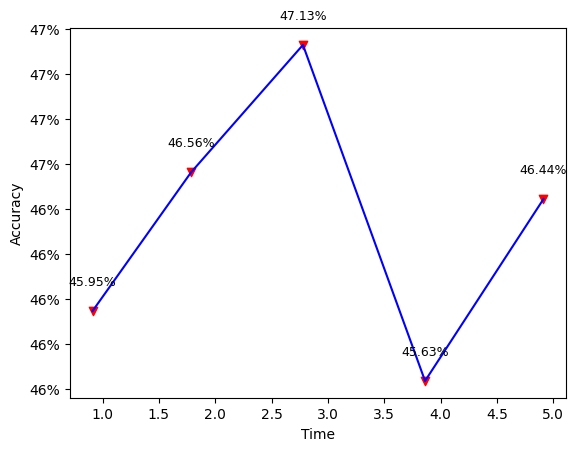

<Figure size 640x480 with 0 Axes>

In [7]:
import numpy as np
import pandas as pd
from progress.bar import Bar
from matplotlib import pyplot as plt
from matplotlib import ticker
import time
import keras
import keras.backend as K


def weightTransform(W, mode = 1, n = 1):

    if mode == 1:
        W_new = W
    elif mode == 2:
        W_new = np.sign(W)
    else:
        W_new = np.round(W * (np.power(2, n)))
    return W_new

def rebuildModel(model_path):

    model = keras.models.load_model(model_path)
    count = 0
    layer_outputs = []
    for layer in model.layers:
        if layer.name.startswith('dropout'):
            break

        if layer.name.startswith('conv1d'):
            weights = layer.get_weights()
            for i in range(len(weights)):
                w = weightTransform(weights[i])
                count = count + np.size(w)
                weights[i] = weightTransform(weights[i])
            layer.set_weights(weights)

        output = layer.output
        layer_outputs.append(output)
    print("Original Weight\nMultiplication Number: ", count)
    model_template = keras.Model(inputs=model.input, outputs=layer_outputs)

    return model_template

def rebuildModelBNN(model_path):

    model = keras.models.load_model(model_path)
    count_inv = 0
    layer_outputs = []
    for layer in model.layers:
        if layer.name.startswith('dropout'):
            break

        if layer.name.startswith('conv1d'):
            weights = layer.get_weights()
            for i in range(len(weights)):
                w = weightTransform(weights[i], 2)
                count_inv = count_inv + np.sum(w < 0)
                weights[i] = weightTransform(weights[i], 2)
            layer.set_weights(weights)

        output = layer.output
        layer_outputs.append(output)
    print("Binary Weight\nInversion Number: ", count_inv)
    model_template = keras.Model(inputs=model.input, outputs=layer_outputs)

    return model_template

def rebuildModelENN(model_path, n):

    model = keras.models.load_model(model_path)
    count = 0
    count_inv = 0
    count_shift = 0
    layer_outputs = []

    for layer in model.layers:
        if layer.name.startswith('dropout'):
            break

        if layer.name.startswith('conv1d'):
            weights = layer.get_weights()
            for i in range(len(weights)):
                w = weightTransform(weights[i], 3, n)
                if i==0:
                    count = count + np.size(w)
                    count_shift = count_shift + np.size(w)
                    count_inv = count_inv + np.sum(w < 0)
                if i==1:
                    count = count + np.size(w)

                weights[i] = weightTransform(weights[i], 3, n) / (np.power(2, n))
            layer.set_weights(weights)

        output = layer.output
        layer_outputs.append(output)
    print("Exponent Weight\nAddition Number: ", count, "Inversion Number: ", count_inv, "Bit-shift Number: ", count_shift)
    model_template = keras.Model(inputs=model.input, outputs=layer_outputs)

    return model_template

def dataProcessing(dataset_path):
    dataset = pd.read_csv(dataset_path)
    patients = pd.unique(dataset['label'])
    users = np.random.choice(patients, int(np.floor(len(patients) / 2)), replace=False)
    test_user = dataset.loc[dataset['label'].isin(users)]
    user_database = test_user.groupby('record').head(1)
    test_user = test_user.sample(n=1000, replace=False)
    test_intruder = test_user.head(len(test_user) // 2)  # Values from first half of test_user
    return user_database, test_user, test_intruder


def databaseGeneration(model, user_database):
    col = [column for column in user_database.columns if column not in ['label', 'record']]
    
    # template, use the outputs from the last layer
    template = model.predict(user_database[col].values)[-1]

    return template

def authentication(model, database, login, threshold):
    login_data = model.predict(login)[-1]

    for login_part in login_data:
        for database_part in database:
            # if np.linalg.norm(login_part - database_part) < threshold:
            if np.corrcoef(login_part, database_part, rowvar = 0)[0][1] > threshold:
                return True

    return False

def login(model, database, test_user, test_intruder, threshold):
    user_number = len(test_user['record'].unique())
    intruder_number = len(test_intruder['record'].unique())

    test_number = user_number + intruder_number

    user_score = 0
    Bar.check_tty = False
    bar = Bar('Verifying Users', max=user_number, fill='#', suffix='%(percent)d%%')
    for user in test_user.groupby('record'):
        login = user[1].drop(columns=['label', 'record']).values        
        if authentication(model, database, login, threshold):
            user_score = user_score + 1
        bar.next()
    bar.finish()
    print("User Accuracy: {:.2%}".format(user_score / user_number))

    intruder_score = 0
    Bar.check_tty = False
    bar = Bar('Verifying Intruders', max=intruder_number, fill='#', suffix='%(percent)d%%')
    for user in test_intruder.groupby('record'):
        login = user[1].drop(columns=['label', 'record']).values        
        if not authentication(model, database, login, threshold):
            intruder_score = intruder_score + 1
        bar.next()
    bar.finish()
    print("Intruder Accuracy: {:.2%}".format(intruder_score / intruder_number))

    accuracy = (user_score + intruder_score) / test_number

    print('Average Accuracy : {:.2%}'.format(accuracy))

    return accuracy


if __name__ == "__main__":

    # model_path = 'testModel.h5'
    #model_path = 'oldmodel.h5'
    model_path = 'model.h5'
    dataset_name = 'PTB_dataset'
    dataset_path =  dataset_name + '.csv'
    accuracy = []
    tim = []
    i=1
   
    start_time = time.time()
    while i < 6:   
        user_database, test_user, test_intruder = dataProcessing(dataset_path)
        #model = rebuildModel(model_path)
    
        #database = databaseGeneration(model, user_database)
    
        #normal_acc = login(model, database, test_user, test_intruder, 10.5)
    
        #accuracy.append(normal_acc)
    
        #model = rebuildModelBNN(model_path)
    
        #database = databaseGeneration(model, user_database)
    
        #bnn_acc = login(model, database, test_user, test_intruder, 135000)
    
        #accuracy.append(bnn_acc)
        
        ##model = rebuildModelENN(model_path, 8)
        
        ##database = databaseGeneration(model, user_database)
        
        ##enn_acc_1 = login(model, database, test_user, test_intruder, 0.94)
       
        ##accuracy.append(enn_acc_1)
        i +=1    
        model = rebuildModelENN(model_path, 3)
        
        database = databaseGeneration(model, user_database)
        
        enn_acc_2 = login(model, database, test_user, test_intruder, 6)
        
        accuracy.append(enn_acc_2)
        
        #model = rebuildModelENN(model_path, 4)
        
        #database = databaseGeneration(model, user_database)
        
        #enn_acc_3 = login(model, database, test_user, test_intruder, 9)
        
        #accuracy.append(enn_acc_3)
        tim.append(time.time() - start_time)
        print (accuracy)
        print (tim)
    net = []
    for tim in tim:
        net.append(tim/60)
    fig, ax = plt.subplots()
    plt.plot(net, accuracy, color='blue')
    plt.scatter(net, accuracy, color='red', marker='v')
    plt.ylabel('Accuracy')
    plt.xlabel('Time')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    for a, b in zip(net, accuracy):
        plt.text(a, b+0.001, '{:.2%}'.format(b), ha='center', va= 'bottom',fontsize=9)
    plt.show()
    plt.savefig('plot_acc_n3.png', format='png')

